In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random

# learners 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV

# decomposition
from sklearn.decomposition import NMF, PCA


# metrics and evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report

# data
from sklearn.datasets import fetch_lfw_people

# misc
from sklearn.exceptions import NotFittedError
from sklearn.model_selection import train_test_split

plt.rcParams['image.cmap'] = "gray"
%matplotlib inline
import warnings
#  Turning off  warnings as  RandomSearchCV() tends to generate quite many of warnings.
warnings.filterwarnings('ignore')

### Load data

In [2]:
# Loading dataset
people = fetch_lfw_people(min_faces_per_person=20, resize=.7)
f"# imgs: {people.data.shape[0]} | Imgs shape: {people.images[0].shape}"

'# imgs: 3023 | Imgs shape: (87, 65)'

In [3]:
# know thy data
print(people["DESCR"])

.. _labeled_faces_in_the_wild_dataset:

The Labeled Faces in the Wild face recognition dataset
------------------------------------------------------

This dataset is a collection of JPEG pictures of famous people collected
over the internet, all details are available on the official website:

    http://vis-www.cs.umass.edu/lfw/

Each picture is centered on a single face. The typical task is called
Face Verification: given a pair of two pictures, a binary classifier
must predict whether the two images are from the same person.

An alternative task, Face Recognition or Face Identification is:
given the picture of the face of an unknown person, identify the name
of the person by referring to a gallery of previously seen pictures of
identified persons.

Both Face Verification and Face Recognition are tasks that are typically
performed on the output of a model trained to perform Face Detection. The
most popular model for Face Detection is called Viola-Jones and is
implemented in the OpenC

#### Inspect images

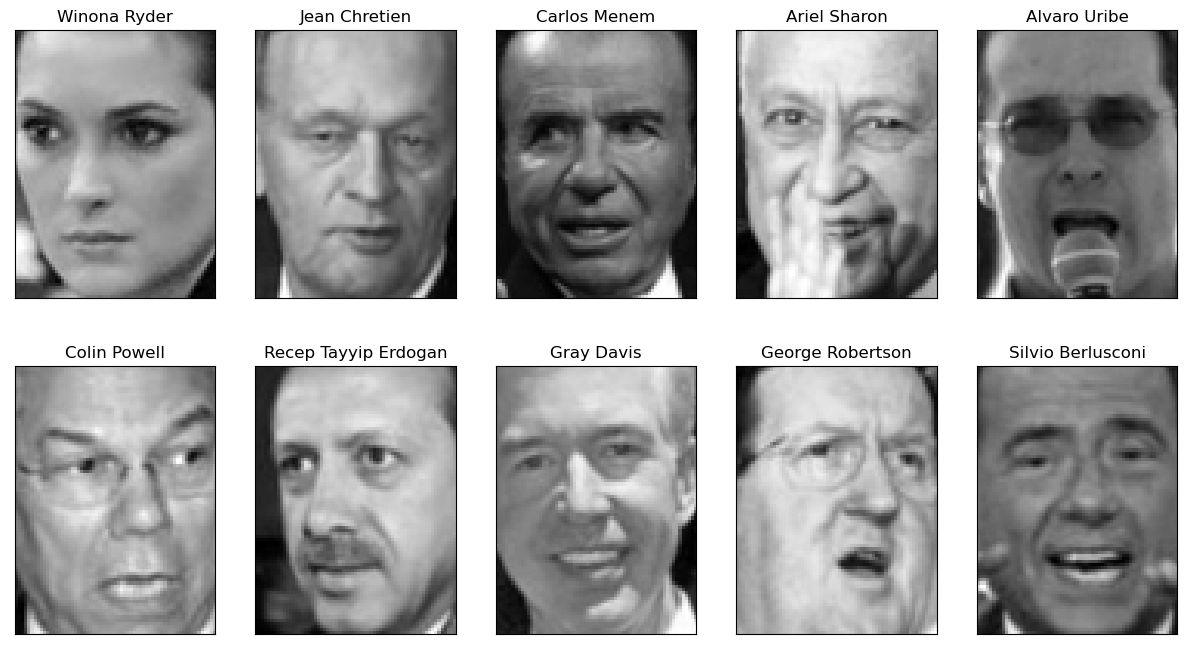

In [4]:
fig, axes = plt.subplots(
    nrows=2, 
    ncols=5, 
    figsize=(15, 8),
    subplot_kw={
        'xticks': (), 
        'yticks': ()
    }
)
for target, image, ax in zip(
    people.target, 
    people.images, 
    axes.ravel()
):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

### Filter and split images and targets

In [5]:
mask = np.zeros(people.target.shape, dtype=bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

# scale the grey-scale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability:
X_people = X_people / 255.

# Question 0

## 0.1 train-test split
- Do a train_test_split of the data. Make sure you use the stratify option, to ensure the same distribution of people in training and test data



In [6]:
# split the data in training and test set
(
    X_train,
    X_test,
    y_train,
    y_test
) = train_test_split(
    X_people,
    y_people,
    stratify=y_people,
    random_state=0
)
# shape of dataset
X_train.shape, X_test.shape

((1547, 5655), (516, 5655))

## 0.2 Target distribution
- Print the target distribution (value counts) for y_train (Consider what insights we can draw from this)

In [7]:
# Target distribution
vc = (
    pd.Series(y_train) 
    .map(pd.Series(people.target_names))
    .value_counts()
)
vc

John Ashcroft        37
Jean Chretien        37
Tony Blair           37
Jacques Chirac       37
George W Bush        37
                     ..
Paul Bremer          15
Jiang Zemin          15
Michael Bloomberg    15
Igor Ivanov          15
Angelina Jolie       15
Length: 62, dtype: int64

<AxesSubplot:>

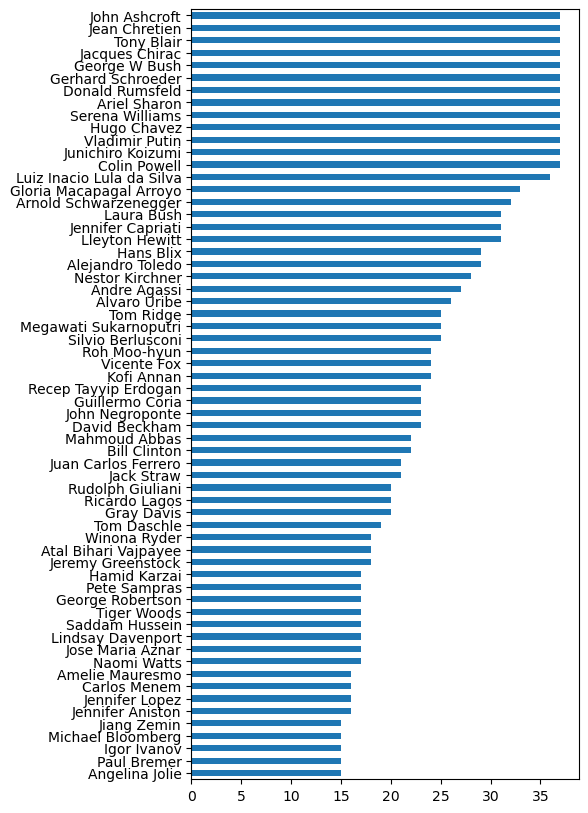

In [8]:
# Sorting the values of the pandas Series object in ascending order
vc_sorted = vc.sort_values()

# Creating a horizontal bar plot using matplotlib and setting the figure size
vc_sorted.plot(kind="barh", figsize=(5, 10))


### Insights from the target distribution
Most learning algorithms assume that we have equally distributed data. In situations with class imbalance, the algorithm tends to develop a bias towards classes the occur more frequently. This, in turn, can lead to poor performance on the less frequent classes. In essence, this happens because learning algorithms are concerned with decreasing error rates, not class distributions: Computationally, it just makes more sense to focus on the larger fish.


In our case, we have classes with more than double the examples of other classes. A priori, we may assume that our ML models will perform better on the classes with high frequency. This, of course, will also depend on the features themselves - If a clear pattern can be observed for a class with just a few examples, the algorithm could decrease it's error rate by "remembering" this pattern. Here, however, the class imbalance is not particularly concerning.

Read more about the multiclass imbalance problem [here](https://machinelearningmastery.com/multi-class-imbalanced-classification/)

### Visualizer class 
To get a visual feel for the performance of our models, we create a class that can show the predicted class, the true class and the top N confidence distribution.

In [10]:
class Visualizer:

    # Initialize the class with the required parameters
    def __init__(
        self,
        imgs,
        targets,
        img_shape = people.images[0].shape,
        names = people.target_names
    ) -> None:
        # Set the attributes of the class
        self.img_shape = img_shape
        self.names = names
        self.imgs = imgs
        self.targets = targets

    # Define the __call__ method of the class which takes a classifier and data as input and generates a plot
    def __call__(self, clf: object, X : np.array) -> None:
        # Try to generate the plot, catch Attribute Error and NotFitted Error exceptions if thrown
        try:
            # Randomly select a data point from the test data
            self.N = random.randint(0, X_test.shape[0])
            # Get the predicted probabilities for the selected data point
            ppl_probas = clf.predict_proba([X[self.N]])[0]
            # Generate the plot for the selected data point and predicted probabilities
            self.generate_plot(ppl_probas, self.N)
        except AttributeError:
            # If the classifier doesn't have predict_proba method, print an error message
            print("Estimator doesn't have predict_proba")
        except NotFittedError:
            # If the classifier is not fitted, print an error message
            print("Estimator is not fitted")
        
    # Define a method to sample an image of the same class as the selected data point based on predicted probabilities
    def sample_img_class(self, probas : np.array) -> int:
        # Select a random data point from the data points with the same class as the predicted class
        return random.sample(
            np.where(self.targets == np.argmax(probas))[0].tolist(), 
            k=1
        )

    # Define a method to get the top k predicted classes and their probabilities
    def get_top_n(self, probas : np.array, k=5) -> tuple:
        # Get the indices of the top k predicted probabilities in descending order
        ind = np.argsort(probas)[::-1][:k]
        # Get the class names and corresponding probabilities for the top k predicted classes
        labels = np.array(self.names)[ind]
        top_probs = probas[ind]
        return labels, top_probs

    def gen_img_plot(self, imshow : np.array, title : str) -> None:
        plt.imshow(imshow.reshape(self.img_shape))
        plt.xticks(())
        plt.yticks(())
        plt.title(title)
            
    # Define a method to generate the plot for the selected data point and predicted probabilities
    def generate_plot(self, probas : np.array, N : int) -> None:
        # Set the grid for the plot
        gs = gridspec.GridSpec(2, 2)
        # Create a new figure for the plot
        plt.figure()

        # Plot the selected data point and true class label
        plt.subplot(gs[0, 0]) # row 0, col 0
        self.gen_img_plot(
            imshow = self.imgs[N],
            title = (
                f"True class:\n {self.names[self.targets[N]]}" +
                f" - {probas[self.targets[N]]:.3f}%"
            )
        )

        # Plot an image of the predicted class and its label
        plt.subplot(gs[0, 1]) # row 0, col 1
        same_class = self.sample_img_class(probas)
        self.gen_img_plot(
            imshow = self.imgs[same_class],
            title = (
                f"Predicted class:\n {self.names[np.argmax(probas)]}" +
                f" - {np.max(probas):.3f}%"
            )
        )
        plt.subplot(gs[1, :]) # row 1, span all columns
        labels, top_probs = self.get_top_n(probas, k=10)
        plt.bar(labels, top_probs)
        plt.xticks(
            rotation=45,
            horizontalalignment='right',
        )
        plt.ylim(0, 1);

        # Plot the top k predicted classes and their probabilities

visualizer = Visualizer(X_test, y_test)

# Question 1
## 1.1 Baseline model - DummyClassifier
- Build a baseline model to compare our performance against, using sklearn's `DummyClassifier`. Fit it on (X_train, y_train) and evaluate on (X_test, y_test)

In [11]:
# Defining model and fitting to training set
clf = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)

# Printing test scores
print(f"Test set score: {clf.score(X_test, y_test):.2f}")

Test set score: 0.03


- *Comment:* NO value that occurs more than x times - 

## 1.2 Candidate Models
- Build both a K Nearest Neighbors and a Logistic Regression model. Fit and evaluate on the same data as above. For the KNN model, set the paramter `n_neighbors` to **1**. 

### KNN Classifier

In [12]:
# Defining model and fitting to training set
knn = KNeighborsClassifier(
    n_neighbors=1, 
    weights='uniform'
).fit(X_train, y_train)

# Reporting scores on training and testing set
print(f"Train set score: {knn.score(X_train, y_train):.2f}")
print(f"Test set score: {knn.score(X_test, y_test):.2f}")

Train set score: 1.00
Test set score: 0.22


- *Comment:* Does much better than the baseline

### Logistic Regression

In [13]:
lr = LogisticRegression(
    solver='lbfgs', 
    multi_class="auto"
).fit(X_train, y_train)

print(f"Train set score: {lr.score(X_train, y_train):.2f}")
print(f"Test set score: {lr.score(X_test, y_test):.2f}")

Train set score: 0.10
Test set score: 0.07


### Model comparison - KNN vs. LR

- Compare the two models - Why might a KNN with n_neighbors=1 perform better? (Hint: Consider the bias/variance tradeoff)

Setting n_neighbors=1, will give the KNN classifier an extremely irregular (or **overfitted**) decision boundary. In contrast, if one configures `n_neighbors=X_train.shape[0]`, the model will effectively be a "most_frequent" DummyClassifier. Why? Because KNN performs a plurality vote of its neighbors, with the object being assigned to the most common class among the considered neighbors. So, as we decrease n_neighbors all the way to 1, we get closer and closer to a "perfect" model of the data set (low bias), but the model will have higher and higher *variance*.

For our data, that means that we will get (relatively) good performance on the exact same data space, but it will likely be too fitted for a new data space. So good performance on the test set would mean that the test data is neigh identical to the train data. We can also see this by the KNN models ability to gain 100% accuracy on train (as compared to LR's measly 0.10%). In general: Be aware of 100% accuracy - Even of training data. [Read more about the bias/variance tradeoff here](http://scott.fortmann-roe.com/docs/BiasVariance.html)

- n = 1 > complex- very overfitted to data. flexible decision boundary. similar data > get good results, but red flag (overfitting). Therefore, question testing scores

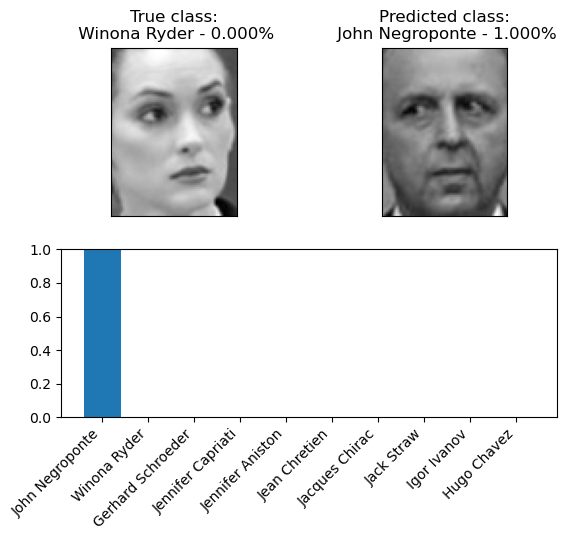

In [14]:
visualizer(clf=knn, X=X_test)

# Question 2


## 2.1 Train PCA Model
- Train a PCA model to (X_train, y_train). Select 100 for the number of components.
- Use the PCA model to transform both X_train and X_test. (Consider using `.fit_transform`)

In [15]:
# Create an instance of PCA with 100 principal components, whitening, and random state of 0
pca = PCA(
    n_components=100,
    whiten=True, 
    random_state=0
)
# Transform the training data using PCA fit and transform method
# Both transform train and test data
X_train_pca = pca.fit_transform(X_train)
# Transform the test data using the previously fitted PCA model
X_test_pca = pca.transform(X_test)

# Print the shape of the transformed training data
f"X_train_pca.shape: {X_train_pca.shape}"

'X_train_pca.shape: (1547, 100)'

## 2.2 Visualize components as imgs
- Plot the 10 (or more) first components as imgs (See section 3.4 - pp. 154 - in the book for this)

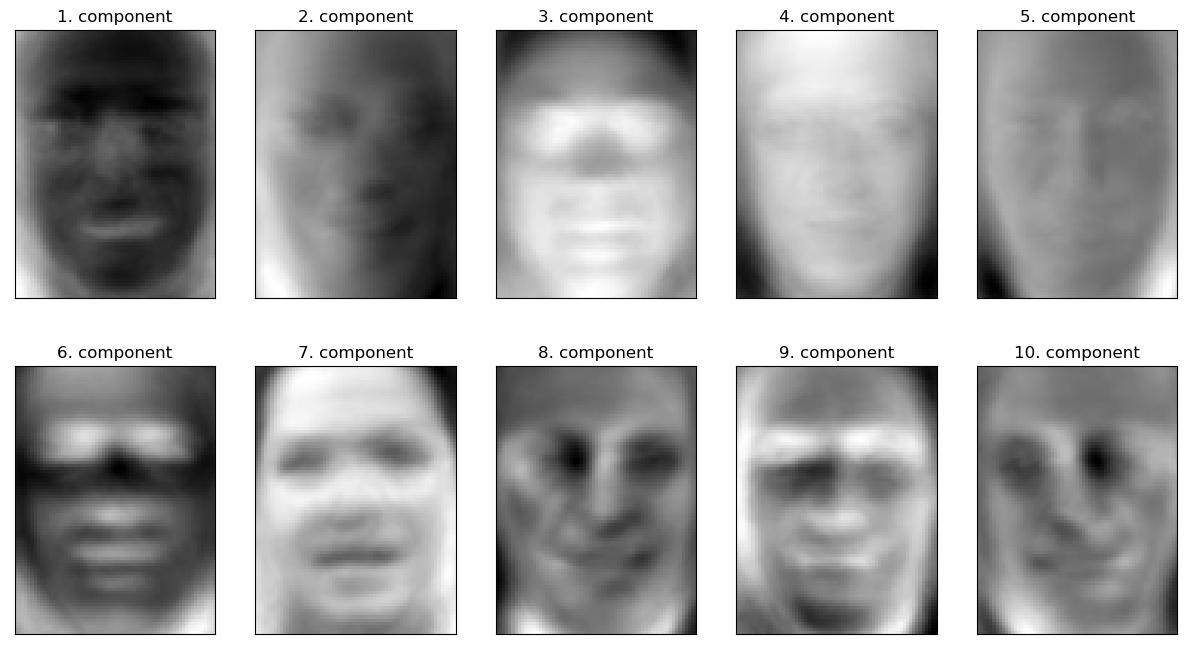

In [16]:
# plot components for single person - visualize components
_, axes = plt.subplots(
    nrows=2,
    ncols=5,
    figsize=(15, 8),
    subplot_kw={
        'xticks': (),
        'yticks': ()
    }
)
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(people.images[0].shape))
    ax.set_title(f"{i + 1}. component")

# Question 3


## 3.1 KNN model with transformed data
- Build a KNN model with this transformed data, and report on the results on the transformed test data. 


In [17]:
# Defining model and fitting to training set
knn = KNeighborsClassifier(
    n_neighbors=1,
    weights='uniform'
).fit(X_train_pca, y_train)

# Reportingscores on training and testing set
print(f"Train set score: {knn.score(X_train_pca, y_train):.2f}")
print(f"Test set score: {knn.score(X_test_pca, y_test):.2f}")

Train set score: 1.00
Test set score: 0.30


- *Insights:* Slightly improvement from 0.22 to 0.30 for the KNN classifier

In [ ]:
# Classification report
# print(
#         classification_report(
#         y_test,
#         knn.predict(X_test_pca),
#         target_names=people.target_names,
#         zero_division=0
#     )
# )

## 3.2 Logistic Regression model with transformed data
- Then try a Logistic Regression model, and report on the result.

In [18]:
# Defining model and fitting to training set
lr = LogisticRegression(
    solver='lbfgs', 
    multi_class="auto"
).fit(X_train_pca, y_train)

# Reporting  scores on training and testing set
print(f"Train set score: {lr.score(X_train_pca, y_train):.2f}")
print(f"Test set score: {lr.score(X_test_pca, y_test):.2f}")

Train set score: 1.00
Test set score: 0.49


- *Insights:* Bigger improvement from the initial model without transformed data

## 3.3 The effect of PCA
- **Comment on the effect on PCA and why it occurs.**

- Bonus: Try to play around with `n_components` in your PCA model. See what the effect.

Finding the 100 principal components of the data clearly has a significant effect on the performance of both models, namely the logistic regression. For LR, we increase performance by 390% (10% -> 49% accuracy)

PCA looks to project each example (data point) into a lower-dimensional space while conserving the variation of the data. In our case, it considers each face and asks: What is unique and what is highly correlated between data points. It leverages this information to iteratively discard, weight and eventually combine features. 

The first principal component can equivalently be defined as a direction that maximizes the variance of the projected data. The *i*th principal component can be taken as a direction orthogonal to the first 
*i* - 1 principal components that maximizes the variance of the projected data.

Text(0, 0.5, 'Classes')

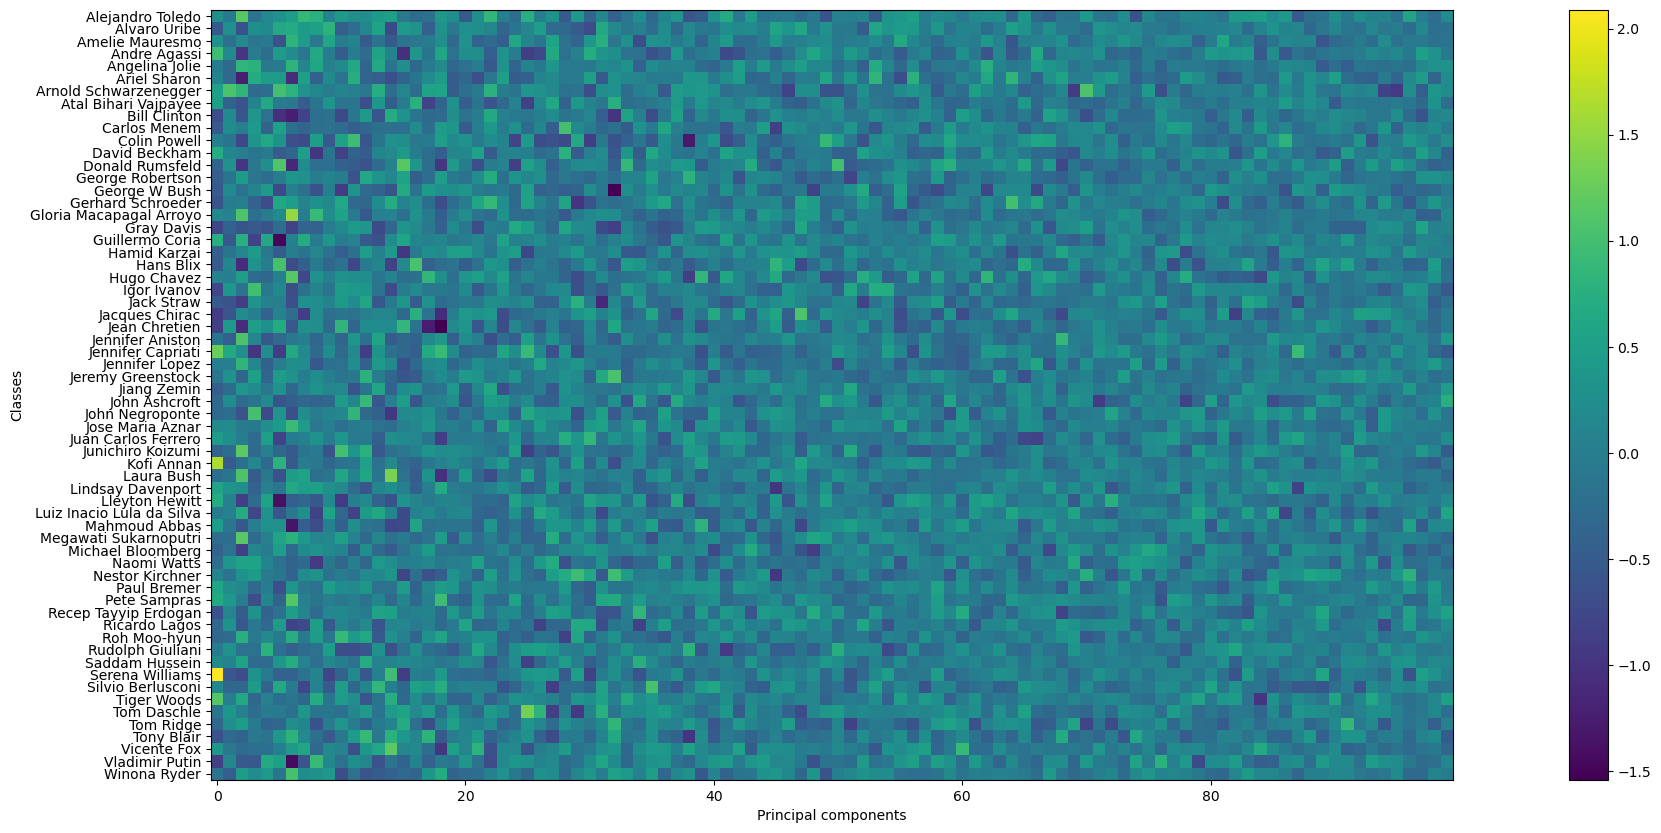

In [19]:
plt.figure(figsize=(30, 10))
plt.imshow(
    lr.coef_,
    cmap='viridis'
)
plt.yticks(
    range(len(people.target_names)),
    people.target_names,
    horizontalalignment='right'
)
plt.colorbar()
plt.xlabel("Principal components")
plt.ylabel("Classes")

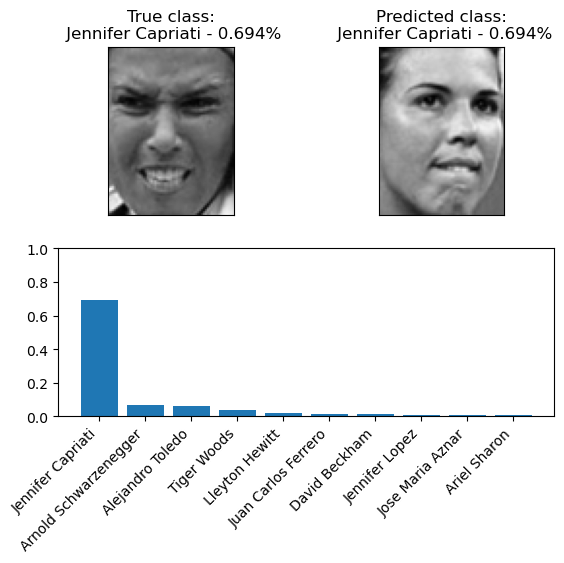

In [20]:
visualizer(clf=lr, X=X_test_pca)

# Question 4


## 4.1 NMF
- Fit NMF components to the train data. Select 100 for the number of components. Use this to transform both X_train and X_test. 



In [21]:
# Instantiate an instance of NMF
nmf = NMF(n_components=5, random_state=0)

# Use the model to transform the train and test data
X_train_nmf = nmf.fit_transform(X_train)
X_test_nmf = nmf.transform(X_test)


- Use the same technique as from 2 to plot the components as images

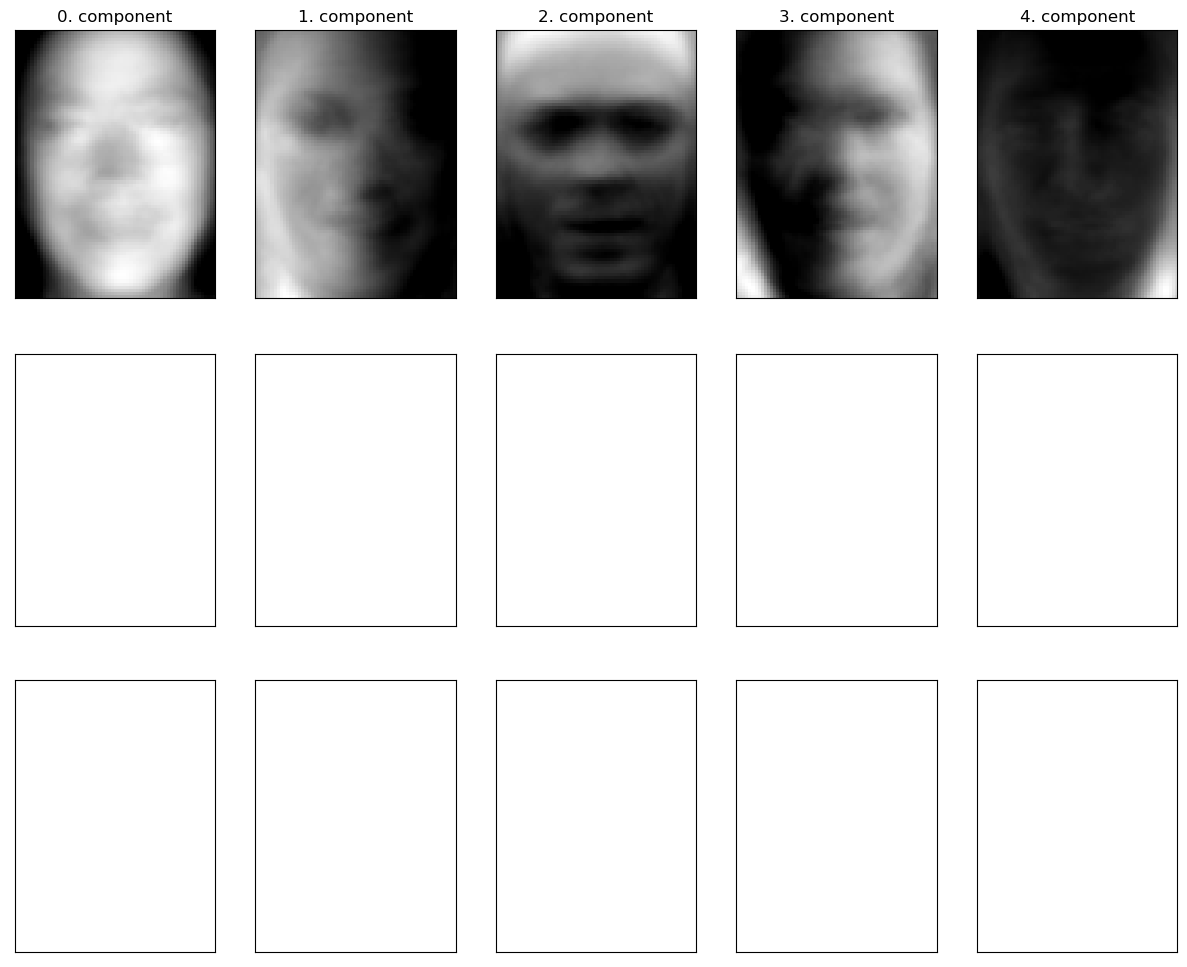

In [23]:
# Visualize
fig, axes = plt.subplots(
   3, 
   5, 
   figsize=(15, 12),
   subplot_kw={
      'xticks': (), 
      'yticks': ()
   }
)
for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
   ax.imshow(component.reshape(people.images[0].shape))
   ax.set_title("{}. component".format(i))

## 4.2 Candidate classifiers with transformed data
- Build both a KNN model and a logistic regression model with this transformed data, and report on the result.

### KNN 

In [24]:
# Instantiating the model
knn = KNeighborsClassifier(n_neighbors=1)
# Fitting the model to training set
knn.fit(X_train_nmf, y_train)
# Reporting  scores on testing set
print("Test set accuracy: {:.2f}".format(knn.score(X_test_nmf, y_test)))

Test set accuracy: 0.06


### Logistic Regression

In [25]:
lr = LogisticRegression(solver='lbfgs', multi_class="auto", max_iter=5000)
lr.fit(X_train_nmf, y_train)
print("Test set accuracy: {:.2f}".format(lr.score(X_test_nmf, y_test)))

Test set accuracy: 0.05


- Don't get as good results for this model. 
- Use dimensionality reduction techniques for visualization and performance

### Neural Network 
- Bonus: Build a neural network (MLP) - As above

### 4.3 Comparison of the effect of NMF and PCA
- **Compare the effect of NMF with the effect of PCA**

NMF splits the images into a set of *basis images*: features that one could interpret as "nose", "eyes" etc, that, when combined, may approximate the original image. In contrast, PCA projects our data to a lower-dimensional space of "generic" faces ordered by how well they capture the original one.

Unlike PCA, NMF learns to represent faces with a set of basis images resembling parts of faces. Consider component 2, 8, 14 (with random_state=0) - These are parts of a face: A forehead, a chin jaw and two chins. 

# Question 5
Let's enact a real-life case scenario, using the same data. Here, (X_train, y_train) will be the data given to your for the project. (X_test, y_test) will be *next* months batch. **Pretend it is not available to you at training time**. Follow the steps below:

## 5.2 Split data
- Make sure you have **ALL** random_states set to 0 (Incl. x_train_test_split's random_state!)
- Split your training data into (X_val, y_val), (X_train, y_train). Remember to set `stratify=True`


In [27]:
# split X_train into training and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    stratify=y_train,
    random_state=0
)

## 5.2 Candidate classifiers - Model for efficency
- Choose one (or more) learning algorithms discussed in class. 
- Build model class for efficiency

In [29]:
# Define an Experiment class
class Experiment:
    def __init__(self):
        # Initialize an empty list to store results
        self.results = []

    # Define a method to run the experiment with the specified classifier, parameters, and data
    def run(self, clf, param_grid, data, scoring='f1_weighted', cv=3, return_train_score=True, verbose=1, **kwargs):
        # Instantiate a GridSearchCV object with the given parameters
        gs_clf = GridSearchCV(
            clf,
            param_grid,
            scoring=scoring,
            cv=cv,
            return_train_score=return_train_score,
            verbose=verbose,
            **kwargs
        ).fit(data["X_train"], data["y_train"])

        # Log the results
        results = self.log_results(gs_clf, data)
        self.results.append(results)

        # Print the results
        if verbose:
            self.print_results(results)

    # Define a method to log the results of the experiment
    def log_results(self, clf, data):
        return {
            "algo": clf.best_estimator_.__class__.__name__,
            "best_params": clf.best_params_,
            "train_score": clf.best_score_,
            "test_score": clf.score(data["X_val"], data["y_val"]),
        }

    # Define a method to print the results of the experiment
    def print_results(self, results):
        for k, v in results.items():
            print(f"{k}: {v}")

    # Define a method to run the experiment with multiple classifiers and parameters
    def run_multiple(self, clfs, param_grids, data, **kwargs):
        # Loop over each classifier and corresponding parameter grid
        for clf, param_grid in zip(clfs, param_grids):
            print(f"Running {clf.__class__.__name__}...")
            # Run the experiment with the current classifier and parameter grid
            self.run(clf, param_grid, data, **kwargs)

        # Return the results as a pandas dataframe
        return pd.DataFrame(self.results)


## 5.3 Transform data using PCA
- Using all techniques used or discussed in class, incl. NMF and PCA (and hyperparamter optimization), train on your (X_train, y_train) and eval the results on (X_val, y_val) - To try build the best model possible

In [30]:
# Instantiating PCA
pca = PCA(n_components=200, whiten=True, random_state=0)
# Apllyting PCA to transform train and validation data
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

pca

PCA(n_components=200, random_state=0, whiten=True)

#### Define learning algorithms and paramter grids

In [31]:
# Defining classifiers
clfs=[
    RandomForestClassifier(),
    LogisticRegression()
]
# Parameter grids
param_grids=[
    
    {
        "n_estimators": [100, 500, 1000],
        # define more parameters
    },
    {
        "C": [0.001, 0.1, 1, 10],
        "solver": ["lbfgs", "liblinear"],
        # define more parameters
    }
]
data={
    "X_train": X_train_pca,
    "y_train": y_train,
    "X_val": X_val_pca,
    "y_val": y_val
}


## 5.4 Train and evaluate
- Show the performance using an accuracy score, confusion matrix and a classification report. 

In [32]:
exp = Experiment()
results_df = exp.run_multiple(
    clfs=clfs,
    param_grids=param_grids,
    data=data,
    verbose=3,
    scoring="accuracy"
)

Running RandomForestClassifier...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END n_estimators=100;, score=(train=1.000, test=0.212) total time=   2.7s
[CV 2/3] END n_estimators=100;, score=(train=1.000, test=0.209) total time=   3.7s
[CV 3/3] END n_estimators=100;, score=(train=1.000, test=0.207) total time=   4.0s
[CV 1/3] END n_estimators=500;, score=(train=1.000, test=0.292) total time=  16.1s
[CV 2/3] END n_estimators=500;, score=(train=1.000, test=0.276) total time=  18.0s
[CV 3/3] END n_estimators=500;, score=(train=1.000, test=0.272) total time=  22.6s
[CV 1/3] END n_estimators=1000;, score=(train=1.000, test=0.284) total time=  23.6s
[CV 2/3] END n_estimators=1000;, score=(train=1.000, test=0.328) total time=  23.5s
[CV 3/3] END n_estimators=1000;, score=(train=1.000, test=0.256) total time=  22.4s
algo: RandomForestClassifier
best_params: {'n_estimators': 1000}
train_score: 0.28962659490433923
test_score: 0.3798449612403101
Running LogisticRegression..

In [33]:
results_df.sort_values(by="test_score", ascending=False, inplace=True)
results_df

,algo,best_params,train_score,test_score
1,LogisticRegression,"{'C': 0.1, 'solver': 'liblinear'}",0.379298,0.483204
0,RandomForestClassifier,{'n_estimators': 1000},0.289627,0.379845


- *Insights:* The  best model is Logistic Regression

In [34]:
best_results = results_df.iloc[0]
best_clf = LogisticRegression(**best_results["best_params"]).fit(X_train_pca, y_train)
y_pred = best_clf.predict(X_val_pca)
print(classification_report(y_val, y_pred, target_names=people.target_names, zero_division=0))

                           precision    recall  f1-score   support

         Alejandro Toledo       0.71      0.71      0.71         7
             Alvaro Uribe       0.43      0.43      0.43         7
          Amelie Mauresmo       0.00      0.00      0.00         4
             Andre Agassi       0.38      0.43      0.40         7
           Angelina Jolie       0.00      0.00      0.00         4
             Ariel Sharon       0.36      0.56      0.43         9
    Arnold Schwarzenegger       0.21      0.38      0.27         8
     Atal Bihari Vajpayee       0.50      0.20      0.29         5
             Bill Clinton       0.25      0.17      0.20         6
             Carlos Menem       0.50      0.25      0.33         4
             Colin Powell       0.50      0.33      0.40         9
            David Beckham       0.33      0.17      0.22         6
          Donald Rumsfeld       0.30      0.33      0.32         9
         George Robertson       1.00      0.75      0.86     

- tuning using training data, cv on part of data
- After finding our best classifier, we reetrain on all the data! and create a classification report

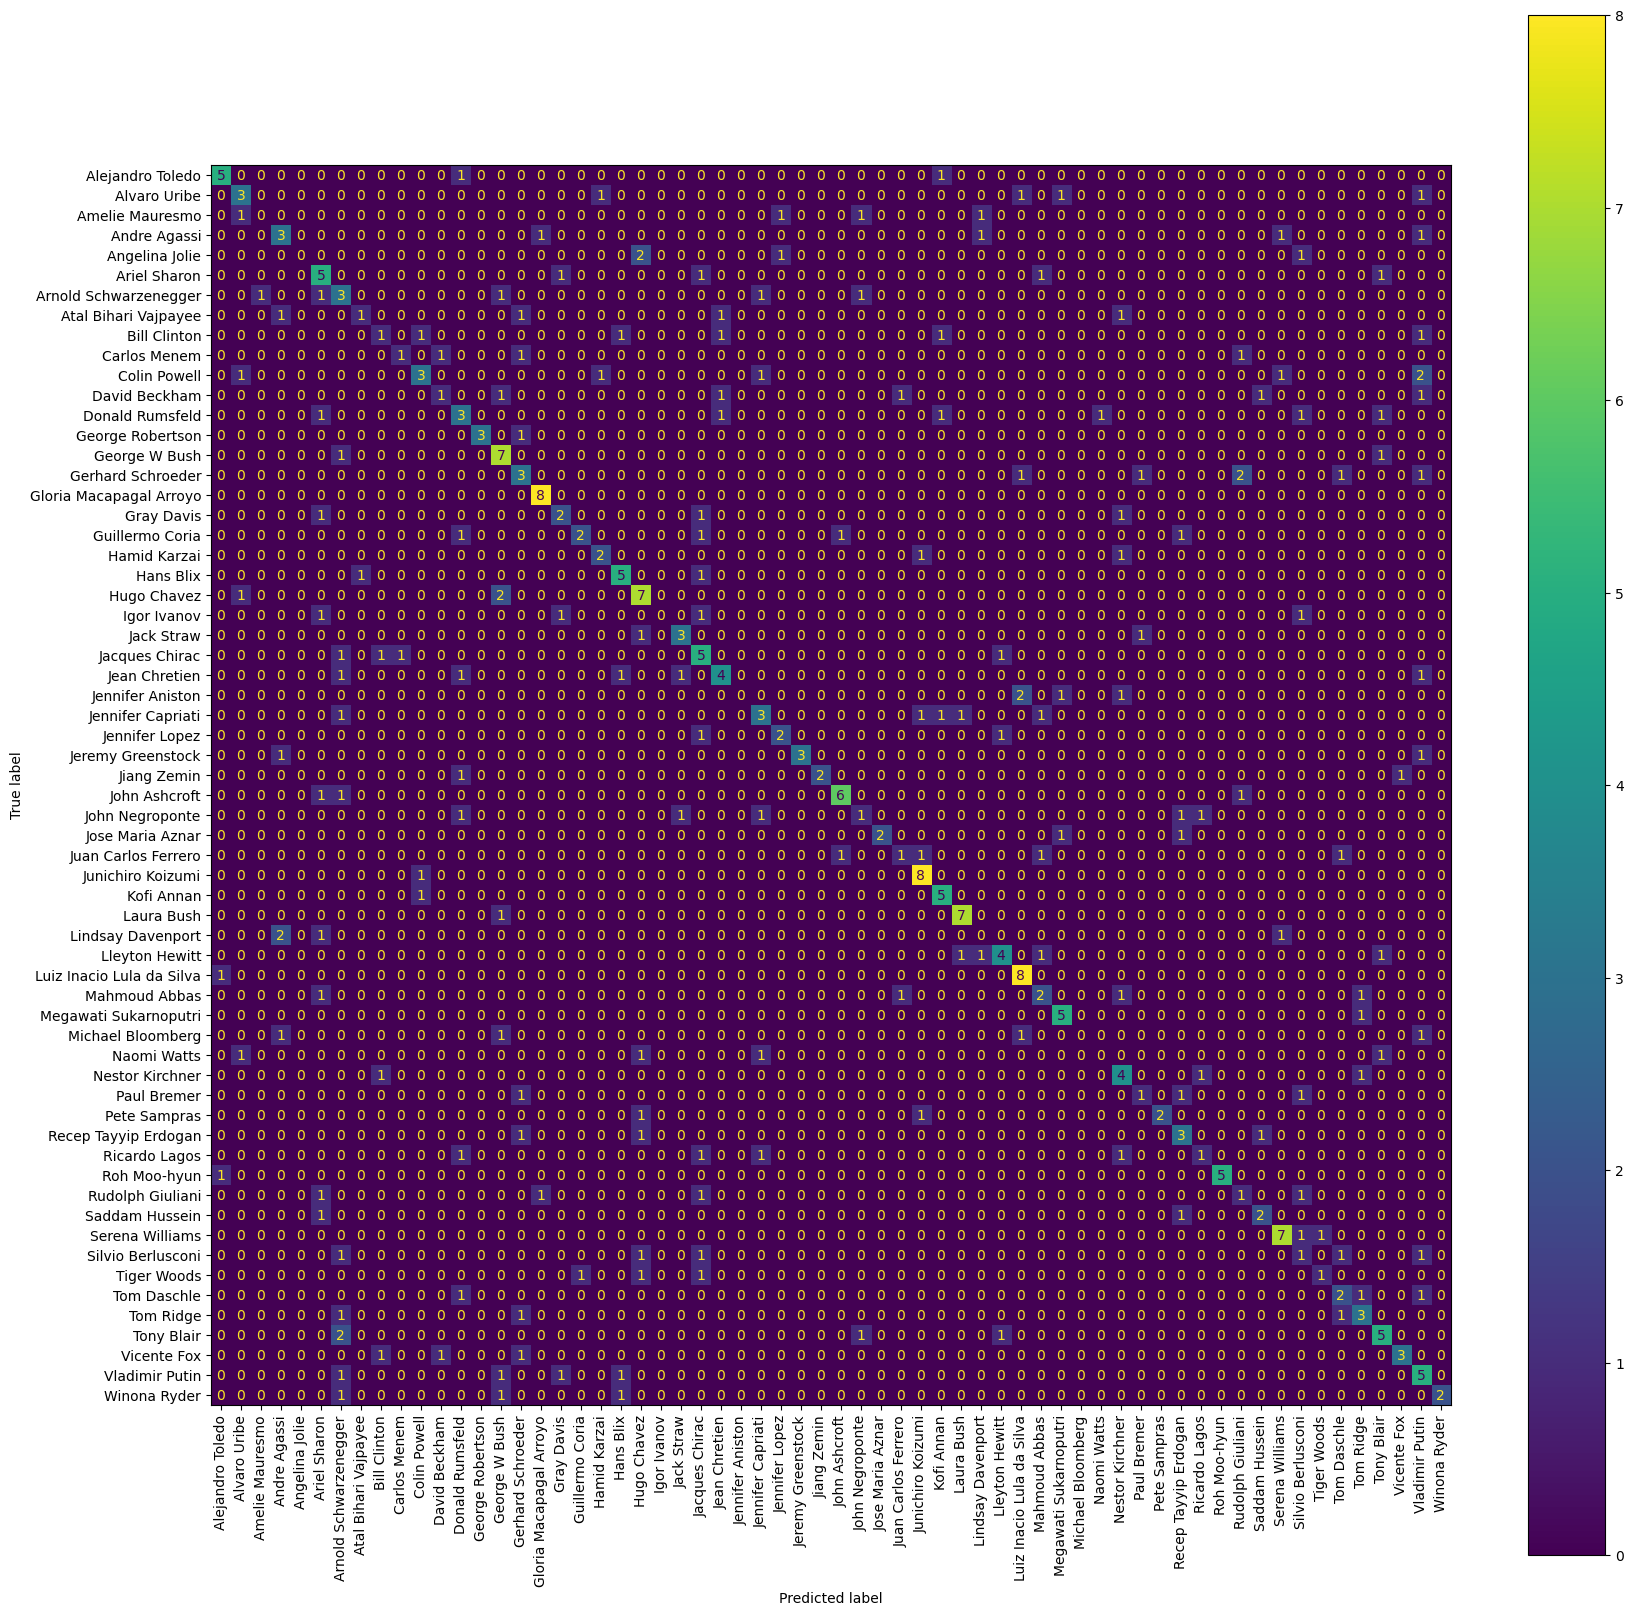

In [35]:
# Confustion matrix
cm = confusion_matrix(y_val, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=people.target_names)
fig, ax = plt.subplots(figsize=(20,20))
cmp.plot(ax=ax, xticks_rotation='vertical')

- Bonus: Report any noteworthy insights (such as class performance imbalances) and write what it might mean for your model in production.

## 5.5 Fit prod model
- Fit a model to combined train and val data (i.e. the original X_train) with the best paramters. This is what we will "push to production"

In [36]:
# fit model on combined X_train and X_val
X_train_prod = np.vstack((X_train_pca, X_val_pca))
y_train_prod = np.hstack((y_train, y_val))
best_clf.fit(X_train_prod, y_train_prod)

LogisticRegression(C=0.1, solver='liblinear')

# Question 6
Pretend it is next month, and you have to score the new data! (Your X_test)

## 6.1 Transform test set with PCA
- Assume that we have painstakenly annotated the data manually (y_test). 

In [37]:
X_test_pca = pca.transform(X_test)

## 6.2 Evaluate on test set
- Evaluate your prod model on (X_test, y_test) - Report the results

In [38]:
# evaluate model on test set
y_pred_test = best_clf.predict(X_test_pca)
print(f"Test set score: {accuracy_score(y_test, y_pred_test):.2f}")
print(classification_report(y_test, y_pred_test, target_names=people.target_names, zero_division=0))

Test set score: 0.51
                           precision    recall  f1-score   support

         Alejandro Toledo       0.54      0.70      0.61        10
             Alvaro Uribe       0.55      0.67      0.60         9
          Amelie Mauresmo       0.75      0.60      0.67         5
             Andre Agassi       0.27      0.33      0.30         9
           Angelina Jolie       0.50      0.20      0.29         5
             Ariel Sharon       0.41      0.54      0.47        13
    Arnold Schwarzenegger       0.10      0.10      0.10        10
     Atal Bihari Vajpayee       0.80      0.67      0.73         6
             Bill Clinton       0.67      0.57      0.62         7
             Carlos Menem       0.25      0.20      0.22         5
             Colin Powell       0.54      0.54      0.54        13
            David Beckham       0.40      0.25      0.31         8
          Donald Rumsfeld       0.57      0.62      0.59        13
         George Robertson       0.50    

## 6.3 Report insights
- Report any noteworthy insights (such as class performance imbalances) and write what it might mean for your model in production.

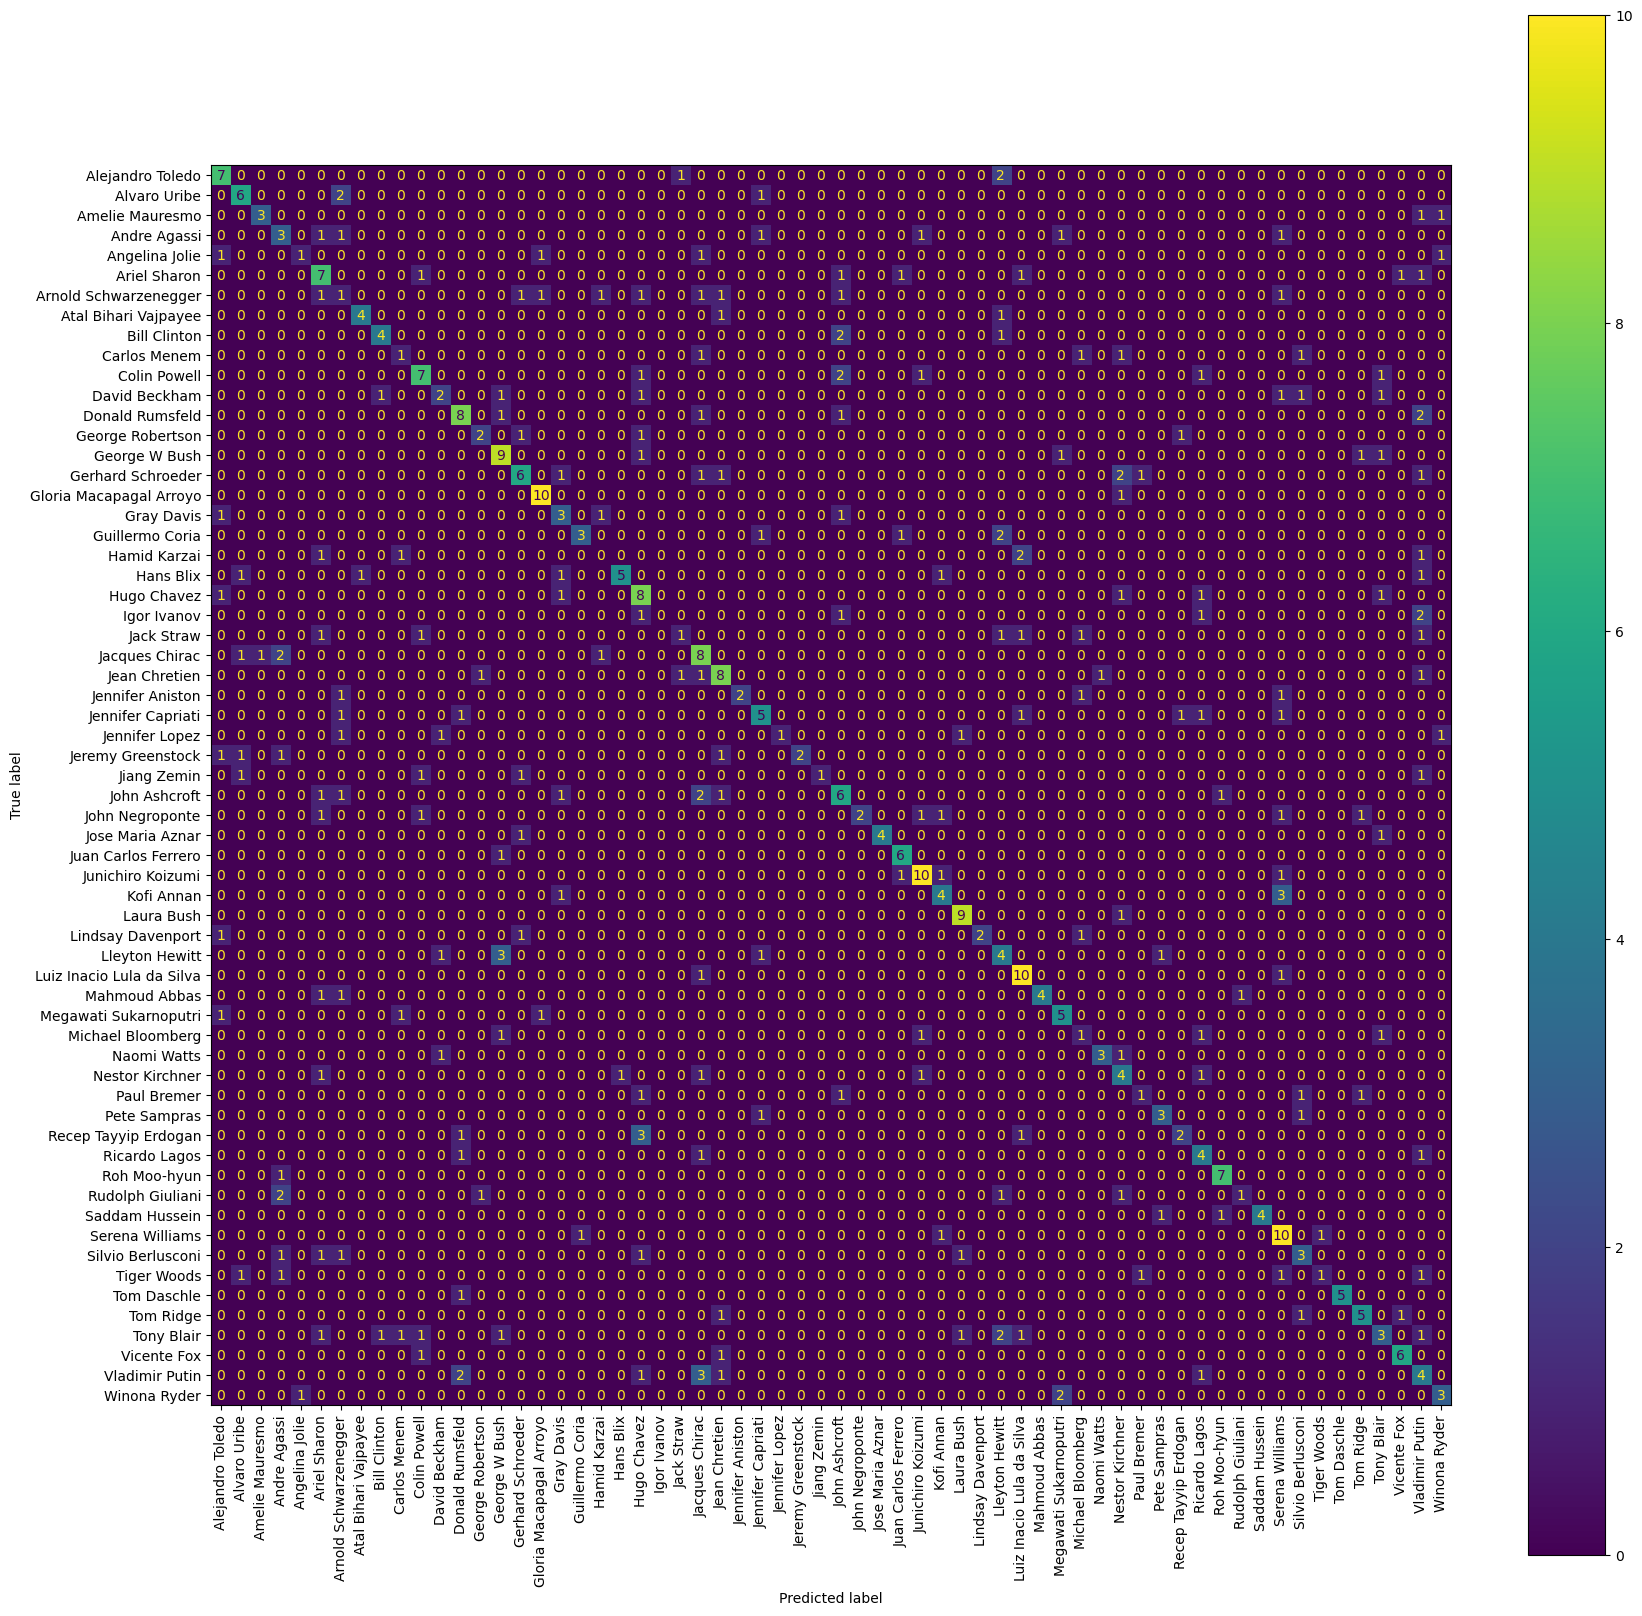

In [39]:
cm = confusion_matrix(y_test, y_pred_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=people.target_names)
fig, ax = plt.subplots(figsize=(20,20))
cmp.plot(ax=ax, xticks_rotation='vertical');